In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import math
from PIL import ImageFilter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Carga de datos

Cada patrón consiste en una imagen de 224x224 píxeles y 3 canales de color

In [2]:
# ImageDataGenerator

height, width = 224, 224
batch_size=64

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.) #estandarizar
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=64,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = 'train'
TESTING_DIR = 'test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


In [3]:
y_train = np.array([])
X_train = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    X_train.append(train_generator[i][0]) 
    y_train= np.concatenate((y_train,train_generator[i][-1])) 
    
X_train = np.concatenate((X_train),axis=0)

In [4]:
y_test = np.array([])
X_test = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    X_test.append(test_generator[i][0]) 
    y_test= np.concatenate((y_test,test_generator[i][-1])) 
    
X_test = np.concatenate((X_test),axis=0)

In [5]:
print(len(X_train))
print(len(X_test))
print(X_test[0].shape)

251
66
(224, 224, 3)


## Visualización de las imágenes

Clase: 2.0


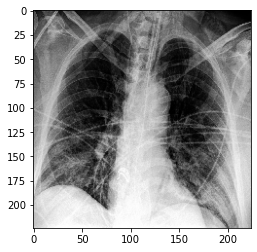

In [6]:
plt.imshow(X_train[0], 'gray')
print("Clase:", y_train[0])

Clase: 0.0


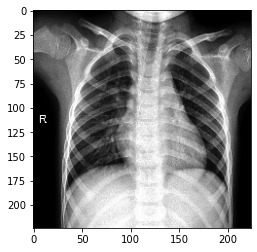

In [7]:
plt.imshow(X_test[2], 'gray')
print("Clase:", y_test[2])

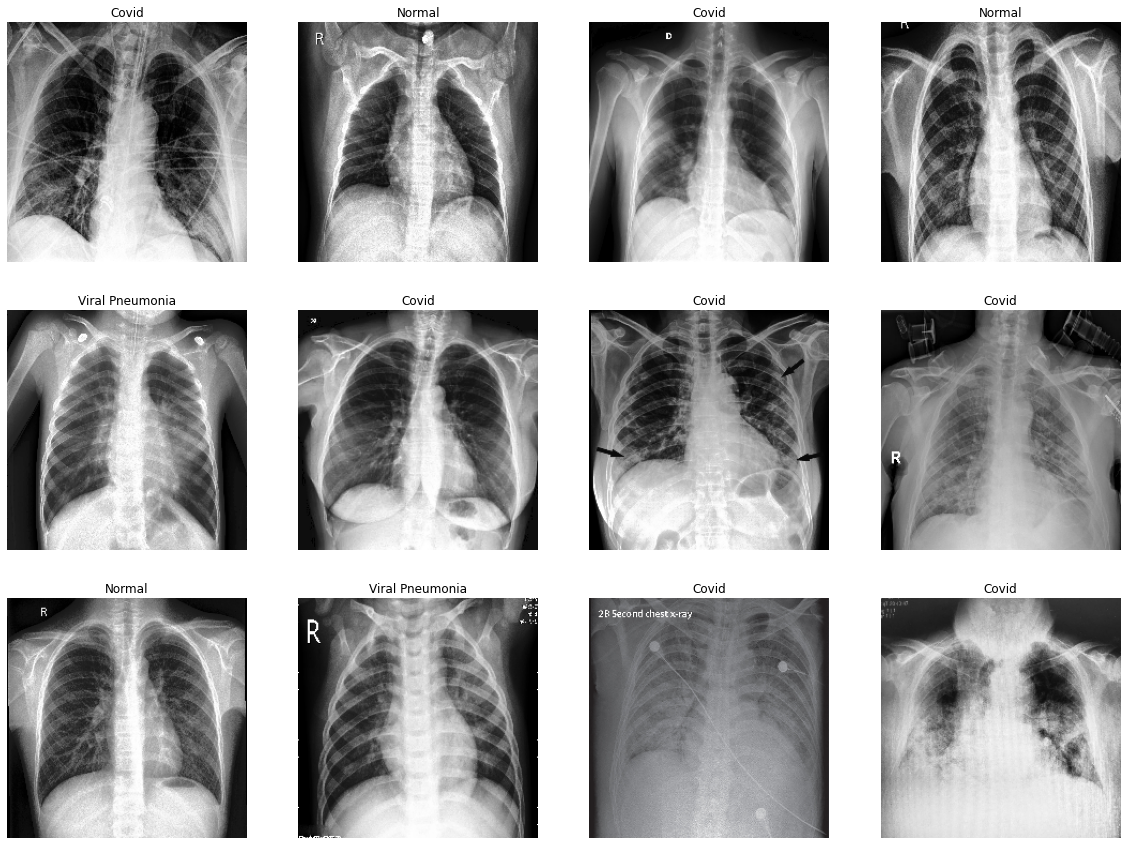

In [8]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,12)

## Codificación del target como variable nominal (ONE-HOT ENCODING)

In [9]:
y_train=y_train.astype('uint8')
y_test=y_test.astype('uint8')

In [10]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

### Modelo lineal (sin capas ocultas)

In [11]:
# La entrada a este tipo de modelo debe ser un array con tantas posiciones como píxeles
# De esta forma, cada imagen de 224x224x3 debe ser convertida en un vector con 150528 variables

trainvectors = X_train.reshape(251, 150528)
testvectors = X_test.reshape(66, 150528)
print(trainvectors.shape)
print(testvectors.shape)

(251, 150528)
(66, 150528)


In [12]:
# El modelo se define de forma secuencial: se definen las capas y se van añadiendo

from keras.models import Sequential
model_0 = Sequential()
# Se define la capa de salida a la cual le llegan todas las conexiones posibles desde la capa de entrada

from keras.layers.core import Dense
denselayer = Dense(3, input_shape=(150528,))
# Se añade dicha capa
model_0.add(denselayer)
# Se añade la función de activación
from keras.layers.core import Activation
model_0.add(Activation('softmax'))
# Se presenta la descripción del modelo
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 451587    
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 451,587
Trainable params: 451,587
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compilación de la red
# Se define la entropia cruzada como función de pérdida a minimizar (apropiada para clasificación multiclase)
# Se utilizar como método de optimización el Stochastic Gradient Descent
# Se incluye también el accuracy como una métrica a evaluar por el modelo
model_0.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [14]:
# Se entrena el modelo
import tensorflow as tf

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

history_0=model_0.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 272ms/step - loss: 21.9577 - accuracy: 0.3500 - val_loss: 247.1906 - val_accuracy: 0.2353
Epoch 2/500
2/2 [==============================] - 0s 65ms/step - loss: 170.5968 - accuracy: 0.3950 - val_loss: 37.1360 - val_accuracy: 0.6863
Epoch 3/500
2/2 [==============================] - 0s 65ms/step - loss: 29.2573 - accuracy: 0.6950 - val_loss: 56.7309 - val_accuracy: 0.4314
Epoch 4/500
2/2 [==============================] - 0s 77ms/step - loss: 47.5543 - accuracy: 0.4900 - val_loss: 88.8138 - val_accuracy: 0.3725
Epoch 5/500
2/2 [==============================] - 0s 102ms/step - loss: 64.3506 - accuracy: 0.5850 - val_loss: 20.1139 - val_accuracy: 0.6863
Epoch 6/500
2/2 [==============================] - 0s 77ms/step - loss: 28.9789 - accuracy: 0.6550 - val_loss: 35.1001 - val_accuracy: 0.6863
Epoch 7/500
2/2 [==============================] - 0s 73ms/step - loss: 22.1016 - accuracy: 0.7150 - val_loss: 25.8846 - val_accuracy: 0.4706
Ep

Epoch 59/500
2/2 [==============================] - 0s 73ms/step - loss: 0.8865 - accuracy: 0.9600 - val_loss: 4.2798 - val_accuracy: 0.8627
Epoch 60/500
2/2 [==============================] - 0s 69ms/step - loss: 1.5109 - accuracy: 0.9250 - val_loss: 3.6705 - val_accuracy: 0.8824
Epoch 61/500
2/2 [==============================] - 0s 71ms/step - loss: 0.8533 - accuracy: 0.9650 - val_loss: 2.1556 - val_accuracy: 0.9216
Epoch 62/500
2/2 [==============================] - 0s 75ms/step - loss: 0.8631 - accuracy: 0.9550 - val_loss: 3.6854 - val_accuracy: 0.8824
Epoch 63/500
2/2 [==============================] - 0s 87ms/step - loss: 0.8910 - accuracy: 0.9600 - val_loss: 3.5582 - val_accuracy: 0.8824
Epoch 64/500
2/2 [==============================] - 0s 73ms/step - loss: 1.0602 - accuracy: 0.9450 - val_loss: 4.8649 - val_accuracy: 0.8431
Epoch 65/500
2/2 [==============================] - 0s 68ms/step - loss: 1.2804 - accuracy: 0.9150 - val_loss: 4.1158 - val_accuracy: 0.8824
Epoch 66/500


Epoch 117/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0448 - accuracy: 0.9900 - val_loss: 1.3406 - val_accuracy: 0.9216
Epoch 118/500
2/2 [==============================] - 0s 69ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 1.7955 - val_accuracy: 0.9020
Epoch 119/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0071 - accuracy: 0.9950 - val_loss: 1.6082 - val_accuracy: 0.9020
Epoch 120/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0070 - accuracy: 0.9950 - val_loss: 1.7321 - val_accuracy: 0.9020
Epoch 121/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.7678 - val_accuracy: 0.9020
Epoch 122/500
2/2 [==============================] - 0s 83ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.7081 - val_accuracy: 0.9020
Epoch 123/500
2/2 [==============================] - 0s 70ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.7012 - val_accuracy: 0.9020
Epoch 

Clases predichas= [2 2 1 2 1 2 0 0 0 1 1 1 2 1 1 1 1 0 2 0 0 2 0 2 1 0 2 2 2 1 1 2 2 0 1 1 1
 2 1 1 2 2 1 1 2 0 0 1 0 0 1 2 2 1 2 1 1 0 2 1 1 2 1 2 0 2]
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.67      0.90      0.77        20
           2       0.92      0.85      0.88        26

    accuracy                           0.79        66
   macro avg       0.79      0.78      0.78        66
weighted avg       0.81      0.79      0.79        66



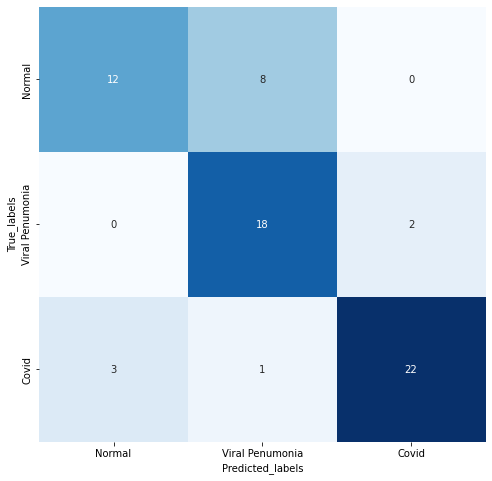

Test loss 5.474442958831787
Test accuracy 0.7878788113594055


In [15]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_0.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_0.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)

from sklearn.metrics import classification_report
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_0.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

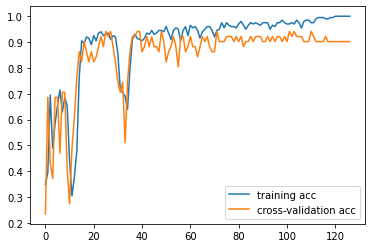

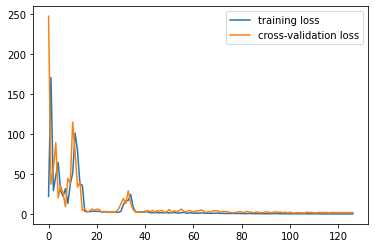

In [16]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_0)

### Red neuronal superficial (con una capa oculta)

In [17]:
model_1 = Sequential()
model_1.add(Dense(32, input_shape=(150528,)))
model_1.add(Activation('sigmoid'))
model_1.add(Dense(3))
model_1.add(Activation('softmax'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                4816928   
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params: 4,817,027
Trainable params: 4,817,027
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compilación de la red
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Se entrena el modelo
history_1=model_1.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 420ms/step - loss: 1.4420 - accuracy: 0.3600 - val_loss: 1.1157 - val_accuracy: 0.4902
Epoch 2/500
2/2 [==============================] - 0s 142ms/step - loss: 1.1314 - accuracy: 0.4300 - val_loss: 0.9121 - val_accuracy: 0.5686
Epoch 3/500
2/2 [==============================] - 0s 90ms/step - loss: 0.9689 - accuracy: 0.5000 - val_loss: 0.9925 - val_accuracy: 0.6667
Epoch 4/500
2/2 [==============================] - 0s 92ms/step - loss: 0.9329 - accuracy: 0.7700 - val_loss: 0.8650 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 0s 91ms/step - loss: 0.8867 - accuracy: 0.7300 - val_loss: 0.9503 - val_accuracy: 0.7059
Epoch 6/500
2/2 [==============================] - 0s 135ms/step - loss: 0.8704 - accuracy: 0.7250 - val_loss: 0.7958 - val_accuracy: 0.8039
Epoch 7/500
2/2 [==============================] - 0s 113ms/step - loss: 0.7871 - accuracy: 0.7450 - val_loss: 0.8419 - val_accuracy: 0.5882
Epoch 8/500
2/2 

2/2 [==============================] - 0s 119ms/step - loss: 0.2468 - accuracy: 0.9400 - val_loss: 0.2754 - val_accuracy: 0.9216
Epoch 60/500
2/2 [==============================] - 0s 92ms/step - loss: 0.2450 - accuracy: 0.9500 - val_loss: 0.3124 - val_accuracy: 0.9020
Epoch 61/500
2/2 [==============================] - 0s 88ms/step - loss: 0.2426 - accuracy: 0.9550 - val_loss: 0.2688 - val_accuracy: 0.9216
Epoch 62/500
2/2 [==============================] - 0s 90ms/step - loss: 0.2434 - accuracy: 0.9400 - val_loss: 0.2833 - val_accuracy: 0.9020
Epoch 63/500
2/2 [==============================] - 0s 91ms/step - loss: 0.2405 - accuracy: 0.9500 - val_loss: 0.3222 - val_accuracy: 0.8824
Epoch 64/500
2/2 [==============================] - 0s 79ms/step - loss: 0.2417 - accuracy: 0.9550 - val_loss: 0.2767 - val_accuracy: 0.9412
Epoch 65/500
2/2 [==============================] - 0s 78ms/step - loss: 0.2476 - accuracy: 0.9300 - val_loss: 0.2804 - val_accuracy: 0.9020
Epoch 66/500
2/2 [=======

Epoch 117/500
2/2 [==============================] - 0s 140ms/step - loss: 0.1634 - accuracy: 0.9700 - val_loss: 0.3110 - val_accuracy: 0.9020
Epoch 118/500
2/2 [==============================] - 0s 104ms/step - loss: 0.1940 - accuracy: 0.9500 - val_loss: 0.2864 - val_accuracy: 0.9020
Epoch 119/500
2/2 [==============================] - 0s 133ms/step - loss: 0.1544 - accuracy: 0.9700 - val_loss: 0.2189 - val_accuracy: 0.9216
Epoch 120/500
2/2 [==============================] - 0s 137ms/step - loss: 0.1506 - accuracy: 0.9650 - val_loss: 0.3331 - val_accuracy: 0.8627
Epoch 121/500
2/2 [==============================] - 0s 121ms/step - loss: 0.1978 - accuracy: 0.9450 - val_loss: 0.2411 - val_accuracy: 0.9412
Epoch 122/500
2/2 [==============================] - 0s 188ms/step - loss: 0.1509 - accuracy: 0.9750 - val_loss: 0.2211 - val_accuracy: 0.9216
Epoch 123/500
2/2 [==============================] - 0s 103ms/step - loss: 0.1423 - accuracy: 0.9700 - val_loss: 0.2290 - val_accuracy: 0.9216

2/2 [==============================] - 0s 87ms/step - loss: 0.1034 - accuracy: 0.9950 - val_loss: 0.2486 - val_accuracy: 0.9020
Epoch 175/500
2/2 [==============================] - 0s 94ms/step - loss: 0.1135 - accuracy: 0.9850 - val_loss: 0.2142 - val_accuracy: 0.9020
Epoch 176/500
2/2 [==============================] - 0s 103ms/step - loss: 0.1008 - accuracy: 0.9900 - val_loss: 0.1960 - val_accuracy: 0.9216
Epoch 177/500
2/2 [==============================] - 0s 89ms/step - loss: 0.1031 - accuracy: 0.9900 - val_loss: 0.2108 - val_accuracy: 0.9020
Epoch 178/500
2/2 [==============================] - 0s 90ms/step - loss: 0.1065 - accuracy: 0.9900 - val_loss: 0.2219 - val_accuracy: 0.9020
Epoch 179/500
2/2 [==============================] - 0s 100ms/step - loss: 0.1032 - accuracy: 0.9900 - val_loss: 0.1928 - val_accuracy: 0.9412
Epoch 180/500
2/2 [==============================] - 0s 101ms/step - loss: 0.1087 - accuracy: 0.9900 - val_loss: 0.1973 - val_accuracy: 0.9412
Epoch 181/500
2/2

2/2 [==============================] - 0s 86ms/step - loss: 0.0808 - accuracy: 0.9900 - val_loss: 0.2123 - val_accuracy: 0.9020
Epoch 232/500
2/2 [==============================] - 0s 90ms/step - loss: 0.0787 - accuracy: 0.9900 - val_loss: 0.2057 - val_accuracy: 0.9020
Epoch 233/500
2/2 [==============================] - 0s 100ms/step - loss: 0.0760 - accuracy: 0.9900 - val_loss: 0.1835 - val_accuracy: 0.9412
Epoch 234/500
2/2 [==============================] - 0s 134ms/step - loss: 0.0768 - accuracy: 0.9950 - val_loss: 0.1813 - val_accuracy: 0.9412
Epoch 235/500
2/2 [==============================] - 0s 110ms/step - loss: 0.0765 - accuracy: 0.9950 - val_loss: 0.1863 - val_accuracy: 0.9216
Epoch 236/500
2/2 [==============================] - 0s 95ms/step - loss: 0.0765 - accuracy: 0.9950 - val_loss: 0.1844 - val_accuracy: 0.9216
Epoch 237/500
2/2 [==============================] - 0s 97ms/step - loss: 0.0738 - accuracy: 0.9900 - val_loss: 0.1940 - val_accuracy: 0.9020
Epoch 238/500
2/2

2/2 [==============================] - 0s 129ms/step - loss: 0.0577 - accuracy: 0.9950 - val_loss: 0.1754 - val_accuracy: 0.9412
Epoch 289/500
2/2 [==============================] - 0s 159ms/step - loss: 0.0567 - accuracy: 0.9950 - val_loss: 0.1841 - val_accuracy: 0.9020
Epoch 290/500
2/2 [==============================] - 0s 137ms/step - loss: 0.0563 - accuracy: 0.9950 - val_loss: 0.1835 - val_accuracy: 0.9020
Epoch 291/500
2/2 [==============================] - 0s 122ms/step - loss: 0.0570 - accuracy: 0.9950 - val_loss: 0.1962 - val_accuracy: 0.9020
Epoch 292/500
2/2 [==============================] - 0s 137ms/step - loss: 0.0565 - accuracy: 0.9950 - val_loss: 0.1703 - val_accuracy: 0.9412
Epoch 293/500
2/2 [==============================] - 0s 107ms/step - loss: 0.0584 - accuracy: 0.9950 - val_loss: 0.1680 - val_accuracy: 0.9412
Epoch 294/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0568 - accuracy: 0.9950 - val_loss: 0.1762 - val_accuracy: 0.9216
Epoch 295/500

Clases predichas= [2 2 1 2 1 2 0 0 0 1 1 1 2 0 1 1 1 0 2 0 0 2 0 2 1 0 2 2 2 1 1 2 2 0 1 1 1
 2 1 0 2 2 1 1 2 0 0 1 0 2 1 2 2 1 2 1 1 0 2 1 1 2 1 2 0 2]
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.68      0.85      0.76        20
           2       0.92      0.88      0.90        26

    accuracy                           0.80        66
   macro avg       0.80      0.79      0.79        66
weighted avg       0.81      0.80      0.80        66



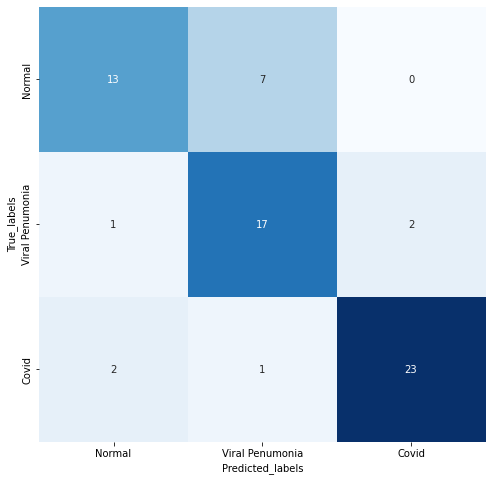

Test loss 0.4241175651550293
Test accuracy 0.8030303120613098


In [19]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_1.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_1.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_1.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

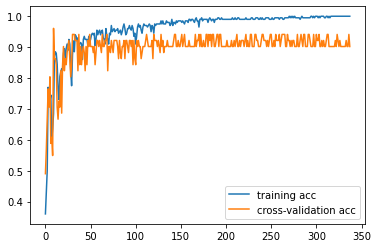

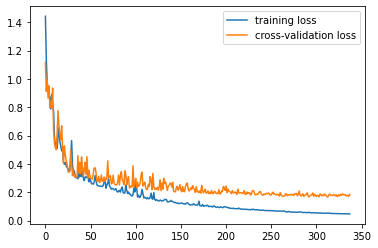

In [20]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_1)

### Red neuronal con dos capas

In [21]:
model_2 = Sequential()
model_2.add(Dense(64, input_shape=(150528,)))
model_2.add(Activation('sigmoid'))
model_2.add(Dense(32, input_shape=(150528,)))
model_2.add(Activation('sigmoid'))
model_2.add(Dense(3))
model_2.add(Activation('softmax'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                9633856   
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
 activation_5 (Activation)   (None, 3)                 0         
                                                                 
Total params: 9,636,035
Trainable params: 9,636,035
No

In [22]:
# Compilación de la red
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Se entrena el modelo

history_2=model_2.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list 
)

Epoch 1/500
2/2 [==============================] - 1s 861ms/step - loss: 1.2762 - accuracy: 0.4300 - val_loss: 1.0909 - val_accuracy: 0.4902
Epoch 2/500
2/2 [==============================] - 0s 185ms/step - loss: 1.1085 - accuracy: 0.4300 - val_loss: 1.0552 - val_accuracy: 0.4902
Epoch 3/500
2/2 [==============================] - 0s 191ms/step - loss: 1.0842 - accuracy: 0.4300 - val_loss: 1.0417 - val_accuracy: 0.4902
Epoch 4/500
2/2 [==============================] - 0s 206ms/step - loss: 1.0650 - accuracy: 0.4300 - val_loss: 1.0241 - val_accuracy: 0.4902
Epoch 5/500
2/2 [==============================] - 0s 180ms/step - loss: 1.0447 - accuracy: 0.4300 - val_loss: 0.9974 - val_accuracy: 0.4902
Epoch 6/500
2/2 [==============================] - 0s 165ms/step - loss: 1.0311 - accuracy: 0.4300 - val_loss: 0.9797 - val_accuracy: 0.4902
Epoch 7/500
2/2 [==============================] - 0s 145ms/step - loss: 1.0107 - accuracy: 0.4300 - val_loss: 0.9638 - val_accuracy: 0.4902
Epoch 8/500
2

Epoch 59/500
2/2 [==============================] - 0s 229ms/step - loss: 0.5420 - accuracy: 0.9200 - val_loss: 0.5380 - val_accuracy: 0.9020
Epoch 60/500
2/2 [==============================] - 0s 203ms/step - loss: 0.5375 - accuracy: 0.9200 - val_loss: 0.5259 - val_accuracy: 0.9216
Epoch 61/500
2/2 [==============================] - 0s 242ms/step - loss: 0.5362 - accuracy: 0.9200 - val_loss: 0.5220 - val_accuracy: 0.9216
Epoch 62/500
2/2 [==============================] - 0s 166ms/step - loss: 0.5317 - accuracy: 0.9250 - val_loss: 0.5258 - val_accuracy: 0.9020
Epoch 63/500
2/2 [==============================] - 0s 153ms/step - loss: 0.5280 - accuracy: 0.9300 - val_loss: 0.5170 - val_accuracy: 0.9412
Epoch 64/500
2/2 [==============================] - 0s 270ms/step - loss: 0.5257 - accuracy: 0.9300 - val_loss: 0.5156 - val_accuracy: 0.9020
Epoch 65/500
2/2 [==============================] - 0s 182ms/step - loss: 0.5224 - accuracy: 0.9200 - val_loss: 0.5114 - val_accuracy: 0.9216
Epoch 

2/2 [==============================] - 0s 152ms/step - loss: 0.4133 - accuracy: 0.9350 - val_loss: 0.4214 - val_accuracy: 0.9216
Epoch 117/500
2/2 [==============================] - 0s 179ms/step - loss: 0.4118 - accuracy: 0.9350 - val_loss: 0.4145 - val_accuracy: 0.9216
Epoch 118/500
2/2 [==============================] - 0s 159ms/step - loss: 0.4110 - accuracy: 0.9350 - val_loss: 0.4138 - val_accuracy: 0.9216
Epoch 119/500
2/2 [==============================] - 0s 149ms/step - loss: 0.4103 - accuracy: 0.9350 - val_loss: 0.4114 - val_accuracy: 0.9412
Epoch 120/500
2/2 [==============================] - 0s 160ms/step - loss: 0.4080 - accuracy: 0.9400 - val_loss: 0.4110 - val_accuracy: 0.9216
Epoch 121/500
2/2 [==============================] - 0s 197ms/step - loss: 0.4090 - accuracy: 0.9350 - val_loss: 0.4079 - val_accuracy: 0.9412
Epoch 122/500
2/2 [==============================] - 0s 128ms/step - loss: 0.4053 - accuracy: 0.9250 - val_loss: 0.4117 - val_accuracy: 0.9216
Epoch 123/500

2/2 [==============================] - 0s 134ms/step - loss: 0.3295 - accuracy: 0.9500 - val_loss: 0.3495 - val_accuracy: 0.9216
Epoch 174/500
2/2 [==============================] - 0s 122ms/step - loss: 0.3285 - accuracy: 0.9500 - val_loss: 0.3502 - val_accuracy: 0.9216
Epoch 175/500
2/2 [==============================] - 0s 156ms/step - loss: 0.3270 - accuracy: 0.9550 - val_loss: 0.3495 - val_accuracy: 0.9216
Epoch 176/500
2/2 [==============================] - 0s 125ms/step - loss: 0.3251 - accuracy: 0.9550 - val_loss: 0.3501 - val_accuracy: 0.9216
Epoch 177/500
2/2 [==============================] - 0s 130ms/step - loss: 0.3245 - accuracy: 0.9500 - val_loss: 0.3452 - val_accuracy: 0.9216
Epoch 178/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3231 - accuracy: 0.9500 - val_loss: 0.3494 - val_accuracy: 0.9216
Epoch 179/500
2/2 [==============================] - 0s 128ms/step - loss: 0.3219 - accuracy: 0.9500 - val_loss: 0.3455 - val_accuracy: 0.9216
Epoch 180/500

2/2 [==============================] - 0s 184ms/step - loss: 0.2655 - accuracy: 0.9600 - val_loss: 0.3064 - val_accuracy: 0.9216
Epoch 231/500
2/2 [==============================] - 0s 180ms/step - loss: 0.2646 - accuracy: 0.9600 - val_loss: 0.3060 - val_accuracy: 0.9216
Epoch 232/500
2/2 [==============================] - 0s 174ms/step - loss: 0.2634 - accuracy: 0.9600 - val_loss: 0.3019 - val_accuracy: 0.9216
Epoch 233/500
2/2 [==============================] - 0s 140ms/step - loss: 0.2624 - accuracy: 0.9550 - val_loss: 0.3088 - val_accuracy: 0.9020
Epoch 234/500
2/2 [==============================] - 0s 174ms/step - loss: 0.2618 - accuracy: 0.9650 - val_loss: 0.2987 - val_accuracy: 0.9216
Epoch 235/500
2/2 [==============================] - 0s 142ms/step - loss: 0.2611 - accuracy: 0.9550 - val_loss: 0.3007 - val_accuracy: 0.9216
Epoch 236/500
2/2 [==============================] - 0s 161ms/step - loss: 0.2598 - accuracy: 0.9550 - val_loss: 0.2983 - val_accuracy: 0.9216
Epoch 237/500

2/2 [==============================] - 0s 157ms/step - loss: 0.2147 - accuracy: 0.9650 - val_loss: 0.2698 - val_accuracy: 0.9216
Epoch 288/500
2/2 [==============================] - 0s 139ms/step - loss: 0.2151 - accuracy: 0.9650 - val_loss: 0.2794 - val_accuracy: 0.9020
Epoch 289/500
2/2 [==============================] - 0s 146ms/step - loss: 0.2140 - accuracy: 0.9750 - val_loss: 0.2683 - val_accuracy: 0.9216
Epoch 290/500
2/2 [==============================] - 0s 153ms/step - loss: 0.2166 - accuracy: 0.9650 - val_loss: 0.2668 - val_accuracy: 0.9216
Epoch 291/500
2/2 [==============================] - 0s 129ms/step - loss: 0.2136 - accuracy: 0.9650 - val_loss: 0.2696 - val_accuracy: 0.9216
Epoch 292/500
2/2 [==============================] - 0s 146ms/step - loss: 0.2104 - accuracy: 0.9700 - val_loss: 0.2689 - val_accuracy: 0.9216
Epoch 293/500
2/2 [==============================] - 0s 152ms/step - loss: 0.2105 - accuracy: 0.9750 - val_loss: 0.2632 - val_accuracy: 0.9216
Epoch 294/500

2/2 [==============================] - 0s 148ms/step - loss: 0.1757 - accuracy: 0.9800 - val_loss: 0.2438 - val_accuracy: 0.9216
Epoch 345/500
2/2 [==============================] - 0s 130ms/step - loss: 0.1740 - accuracy: 0.9850 - val_loss: 0.2444 - val_accuracy: 0.9216
Epoch 346/500
2/2 [==============================] - 0s 143ms/step - loss: 0.1735 - accuracy: 0.9800 - val_loss: 0.2475 - val_accuracy: 0.9020
Epoch 347/500
2/2 [==============================] - 0s 183ms/step - loss: 0.1729 - accuracy: 0.9800 - val_loss: 0.2406 - val_accuracy: 0.9216
Epoch 348/500
2/2 [==============================] - 0s 141ms/step - loss: 0.1725 - accuracy: 0.9800 - val_loss: 0.2417 - val_accuracy: 0.9216
Epoch 349/500
2/2 [==============================] - 0s 141ms/step - loss: 0.1729 - accuracy: 0.9800 - val_loss: 0.2559 - val_accuracy: 0.9020
Epoch 350/500
2/2 [==============================] - 0s 137ms/step - loss: 0.1732 - accuracy: 0.9800 - val_loss: 0.2450 - val_accuracy: 0.9020
Epoch 351/500

2/2 [==============================] - 0s 131ms/step - loss: 0.1440 - accuracy: 0.9850 - val_loss: 0.2333 - val_accuracy: 0.9020
Epoch 402/500
2/2 [==============================] - 0s 125ms/step - loss: 0.1433 - accuracy: 0.9850 - val_loss: 0.2237 - val_accuracy: 0.9216
Epoch 403/500
2/2 [==============================] - 0s 139ms/step - loss: 0.1433 - accuracy: 0.9900 - val_loss: 0.2307 - val_accuracy: 0.9020
Epoch 404/500
2/2 [==============================] - 0s 148ms/step - loss: 0.1426 - accuracy: 0.9850 - val_loss: 0.2260 - val_accuracy: 0.9020
Epoch 405/500
2/2 [==============================] - 0s 134ms/step - loss: 0.1418 - accuracy: 0.9850 - val_loss: 0.2302 - val_accuracy: 0.9020
Epoch 406/500
2/2 [==============================] - 0s 140ms/step - loss: 0.1424 - accuracy: 0.9850 - val_loss: 0.2307 - val_accuracy: 0.9020
Epoch 407/500
2/2 [==============================] - 0s 127ms/step - loss: 0.1434 - accuracy: 0.9850 - val_loss: 0.2372 - val_accuracy: 0.9020
Epoch 408/500

2/2 [==============================] - 0s 150ms/step - loss: 0.1197 - accuracy: 0.9900 - val_loss: 0.2137 - val_accuracy: 0.9020
Epoch 459/500
2/2 [==============================] - 0s 164ms/step - loss: 0.1189 - accuracy: 0.9950 - val_loss: 0.2136 - val_accuracy: 0.9020
Epoch 460/500
2/2 [==============================] - 0s 153ms/step - loss: 0.1190 - accuracy: 0.9950 - val_loss: 0.2186 - val_accuracy: 0.9020
Epoch 461/500
2/2 [==============================] - 0s 153ms/step - loss: 0.1185 - accuracy: 0.9950 - val_loss: 0.2166 - val_accuracy: 0.9020
Epoch 462/500
2/2 [==============================] - 0s 158ms/step - loss: 0.1178 - accuracy: 0.9950 - val_loss: 0.2098 - val_accuracy: 0.9020
Epoch 463/500
2/2 [==============================] - 0s 168ms/step - loss: 0.1173 - accuracy: 0.9950 - val_loss: 0.2121 - val_accuracy: 0.9020
Epoch 464/500
2/2 [==============================] - 0s 154ms/step - loss: 0.1167 - accuracy: 0.9950 - val_loss: 0.2128 - val_accuracy: 0.9020
Epoch 465/500

Clases predichas= [2 2 1 2 1 2 0 0 0 1 1 1 2 0 1 1 1 0 2 0 0 2 0 2 1 0 2 2 2 1 1 2 2 0 1 1 1
 2 1 0 2 2 0 1 2 0 0 1 0 2 1 2 2 1 2 1 1 0 2 1 1 2 1 2 0 2]
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        20
           1       0.67      0.80      0.73        20
           2       0.92      0.88      0.90        26

    accuracy                           0.79        66
   macro avg       0.78      0.78      0.78        66
weighted avg       0.80      0.79      0.79        66



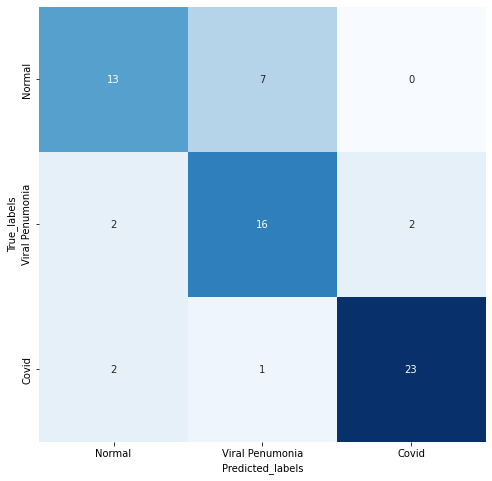

Test loss 0.4226245582103729
Test accuracy 0.7878788113594055


In [23]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_2.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_2.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_2.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

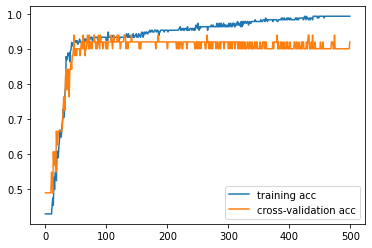

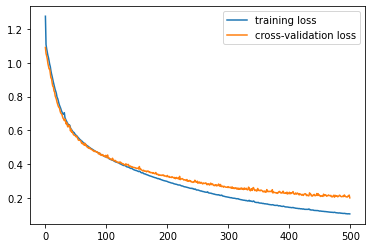

In [24]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_2)

### Red neuronal con dos capas, activación relu y solver adam

In [25]:
model_2ra = Sequential()
model_2ra.add(Dense(64, input_shape=(150528,)))
model_2ra.add(Activation('relu'))
model_2ra.add(Dense(32, input_shape=(150528,)))
model_2ra.add(Activation('relu'))
model_2ra.add(Dense(3))
model_2ra.add(Activation('softmax'))
model_2ra.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                9633856   
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
 activation_8 (Activation)   (None, 3)                 0         
                                                                 
Total params: 9,636,035
Trainable params: 9,636,035
No

In [26]:
# Compilación de la red
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_2ra.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_2ra=model_2ra.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list 
)

Epoch 1/500
2/2 [==============================] - 1s 355ms/step - loss: 27.0694 - accuracy: 0.3750 - val_loss: 16.6288 - val_accuracy: 0.3137
Epoch 2/500
2/2 [==============================] - 0s 171ms/step - loss: 20.5100 - accuracy: 0.3350 - val_loss: 13.9536 - val_accuracy: 0.6667
Epoch 3/500
2/2 [==============================] - 0s 163ms/step - loss: 16.1713 - accuracy: 0.6250 - val_loss: 11.1870 - val_accuracy: 0.5098
Epoch 4/500
2/2 [==============================] - 0s 173ms/step - loss: 10.5250 - accuracy: 0.5400 - val_loss: 1.0152 - val_accuracy: 0.6667
Epoch 5/500
2/2 [==============================] - 0s 157ms/step - loss: 2.0382 - accuracy: 0.6900 - val_loss: 2.6986 - val_accuracy: 0.6863
Epoch 6/500
2/2 [==============================] - 0s 165ms/step - loss: 1.8349 - accuracy: 0.7400 - val_loss: 1.0497 - val_accuracy: 0.8235
Epoch 7/500
2/2 [==============================] - 0s 157ms/step - loss: 1.2276 - accuracy: 0.7800 - val_loss: 0.4644 - val_accuracy: 0.8431
Epoch 

Epoch 59/500
2/2 [==============================] - 0s 247ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.2896 - val_accuracy: 0.9020
Epoch 60/500
2/2 [==============================] - 0s 210ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.2504 - val_accuracy: 0.9020
Epoch 61/500
2/2 [==============================] - 0s 173ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.9020
Epoch 62/500
2/2 [==============================] - 0s 170ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.2605 - val_accuracy: 0.9020
Epoch 63/500
2/2 [==============================] - 0s 157ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.2906 - val_accuracy: 0.9020
Epoch 64/500
2/2 [==============================] - 0s 168ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.2905 - val_accuracy: 0.9020
Epoch 65/500
2/2 [==============================] - 0s 150ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.2557 - val_accuracy: 0.9020
Epoch 

Clases predichas= [2 2 1 2 1 2 0 0 0 1 1 1 2 1 1 1 1 0 2 0 0 2 0 2 1 0 2 2 2 1 1 2 2 0 1 1 1
 2 1 1 2 2 1 1 2 0 0 1 0 2 1 2 2 1 2 1 1 0 2 1 1 2 1 2 0 2]
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        20
           1       0.67      0.90      0.77        20
           2       0.92      0.88      0.90        26

    accuracy                           0.80        66
   macro avg       0.81      0.79      0.79        66
weighted avg       0.82      0.80      0.80        66



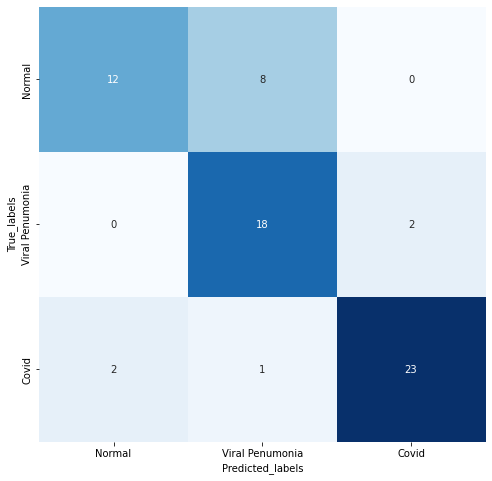

Test loss 0.6647605299949646
Test accuracy 0.8030303120613098


In [27]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_2ra.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_2ra.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_2ra.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

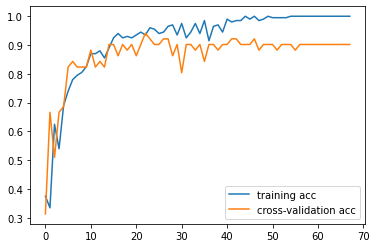

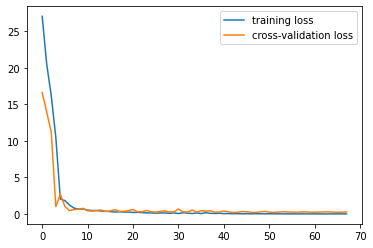

In [28]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_2ra)

### Red neuronal con dos capas y regularizador DROPOUT

In [29]:
# Se busca evitar desvanecimiento del gradiente (tenemos ya más de una capa)
# Además, el término regularizador suele ayudar a que el modelo sobreajuste menos
# Mayor porcentaje de dropout en capas cercanas a la salida

from keras.layers.core import Dropout
model_2rad = Sequential()
model_2rad.add(Dense(64, input_shape=(150528,)))
model_2rad.add(Activation('relu'))
model_2rad.add(Dropout(0.1))
model_2rad.add(Dense(32, input_shape=(150528,)))
model_2rad.add(Activation('relu'))
model_2rad.add(Dropout(0.2))
model_2rad.add(Dense(3))
model_2rad.add(Activation('softmax'))
model_2rad.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                9633856   
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 activation_10 (Activation)  (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                

In [30]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_2rad.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_2rad=model_2rad.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 373ms/step - loss: 15.4739 - accuracy: 0.3100 - val_loss: 24.2700 - val_accuracy: 0.2745
Epoch 2/500
2/2 [==============================] - 0s 144ms/step - loss: 28.1944 - accuracy: 0.3650 - val_loss: 8.4093 - val_accuracy: 0.6471
Epoch 3/500
2/2 [==============================] - 0s 210ms/step - loss: 19.7594 - accuracy: 0.5050 - val_loss: 11.8846 - val_accuracy: 0.7059
Epoch 4/500
2/2 [==============================] - 0s 213ms/step - loss: 16.5806 - accuracy: 0.5350 - val_loss: 0.8809 - val_accuracy: 0.8431
Epoch 5/500
2/2 [==============================] - 0s 155ms/step - loss: 10.0920 - accuracy: 0.5700 - val_loss: 3.4216 - val_accuracy: 0.5294
Epoch 6/500
2/2 [==============================] - 0s 151ms/step - loss: 11.2696 - accuracy: 0.4800 - val_loss: 1.4737 - val_accuracy: 0.8235
Epoch 7/500
2/2 [==============================] - 0s 136ms/step - loss: 10.4532 - accuracy: 0.5500 - val_loss: 2.8962 - val_accuracy: 0.7059
Epoc

Epoch 59/500
2/2 [==============================] - 0s 140ms/step - loss: 0.2988 - accuracy: 0.8900 - val_loss: 0.3655 - val_accuracy: 0.8824
Epoch 60/500
2/2 [==============================] - 0s 147ms/step - loss: 0.2859 - accuracy: 0.8900 - val_loss: 0.2815 - val_accuracy: 0.9412
Epoch 61/500
2/2 [==============================] - 0s 133ms/step - loss: 0.2486 - accuracy: 0.9000 - val_loss: 0.2863 - val_accuracy: 0.9216


Clases predichas= [2 2 0 2 0 2 0 0 0 1 1 1 2 0 1 1 0 0 2 0 0 2 0 2 1 0 2 2 2 1 1 2 2 0 1 1 1
 2 0 0 2 2 0 1 2 0 0 1 0 0 1 2 2 1 2 0 1 0 2 1 1 2 0 2 0 2]
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        20
           1       0.89      0.80      0.84        20
           2       0.92      0.85      0.88        26

    accuracy                           0.86        66
   macro avg       0.87      0.87      0.86        66
weighted avg       0.87      0.86      0.86        66



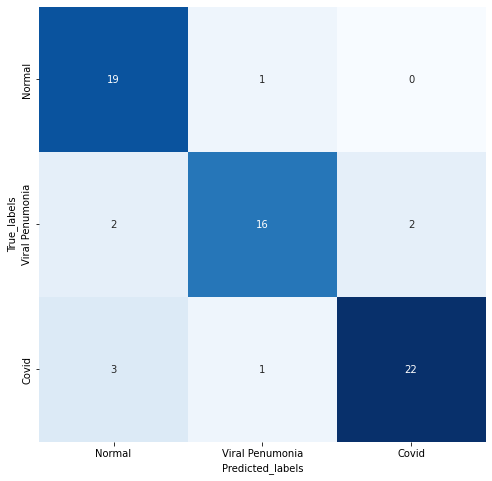

Test loss 0.5466064214706421
Test accuracy 0.8636363744735718


In [31]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_2rad.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_2rad.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_2rad.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

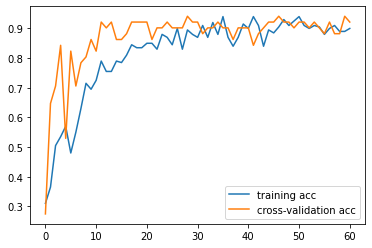

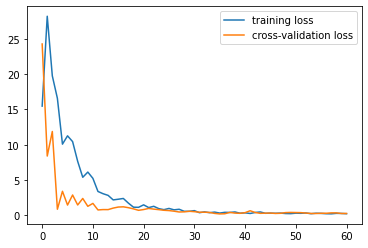

In [32]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_2rad)

### Red neuronal con tres capas

In [33]:
# Se busca evitar desvanecimiento del gradiente (tenemos ya más de una capa)
# Además, el término regularizador suele ayudar a que el modelo sobreajuste menos
# Mayor porcentaje de dropout en capas cercanas a la salida

from keras.layers.core import Dropout
model_3rad = Sequential()
model_3rad.add(Dense(64, input_shape=(150528,)))
model_3rad.add(Activation('relu'))
#model_3rad.add(Dropout(0.05))
model_3rad.add(Dense(32, input_shape=(150528,)))
model_3rad.add(Activation('relu'))
#model_3rad.add(Dropout(0.1))
model_3rad.add(Dense(16, input_shape=(150528,)))
model_3rad.add(Activation('relu'))
#model_3rad.add(Dropout(0.2))
model_3rad.add(Dense(3))
model_3rad.add(Activation('softmax'))
model_3rad.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                9633856   
                                                                 
 activation_12 (Activation)  (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 activation_13 (Activation)  (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 activation_14 (Activation)  (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 3)                

In [34]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_3rad.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_3rad=model_3rad.fit(
    trainvectors, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 1s 355ms/step - loss: 17.7045 - accuracy: 0.3200 - val_loss: 18.4160 - val_accuracy: 0.4902
Epoch 2/500
2/2 [==============================] - 0s 143ms/step - loss: 17.2783 - accuracy: 0.3350 - val_loss: 5.8491 - val_accuracy: 0.2549
Epoch 3/500
2/2 [==============================] - 0s 142ms/step - loss: 4.1331 - accuracy: 0.3600 - val_loss: 3.5711 - val_accuracy: 0.4902
Epoch 4/500
2/2 [==============================] - 0s 150ms/step - loss: 3.1443 - accuracy: 0.4650 - val_loss: 0.8349 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 0s 154ms/step - loss: 0.8312 - accuracy: 0.8300 - val_loss: 2.2699 - val_accuracy: 0.6275
Epoch 6/500
2/2 [==============================] - 0s 150ms/step - loss: 1.2605 - accuracy: 0.7900 - val_loss: 0.4187 - val_accuracy: 0.9216
Epoch 7/500
2/2 [==============================] - 0s 125ms/step - loss: 0.5326 - accuracy: 0.8900 - val_loss: 0.9756 - val_accuracy: 0.8235
Epoch 8/50

Clases predichas= [2 2 1 2 1 2 0 0 0 1 1 1 2 1 1 1 1 0 2 0 0 2 0 2 1 0 2 2 2 2 1 2 2 0 1 1 1
 2 1 1 2 2 1 1 2 0 0 1 0 2 1 2 2 1 2 1 1 0 2 1 1 2 0 2 0 2]
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.72      0.90      0.80        20
           2       0.92      0.92      0.92        26

    accuracy                           0.83        66
   macro avg       0.84      0.82      0.82        66
weighted avg       0.84      0.83      0.83        66



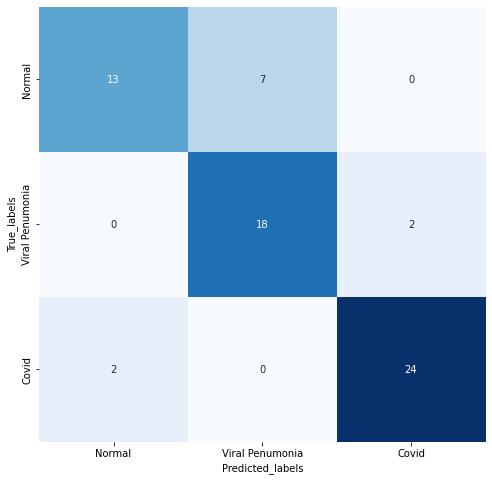

Test loss 0.7551832795143127
Test accuracy 0.8333333134651184


In [35]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_3rad.predict(testvectors, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_3rad.predict(testvectors, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_3rad.evaluate(testvectors, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

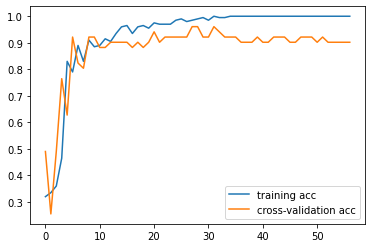

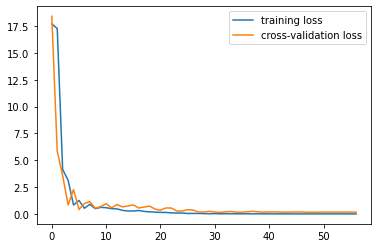

In [36]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_3rad)

### Red neuronal convolucional

In [37]:
# En este caso, ya no vale la estructura vectorial, 
# sino que lo datos deben ser guardados como tensores 
# haciendo referencia a la imagen tal y como fue leída originalmente (nº filas x nº columnas) 
# y al número de canales de color (en este caso 1)

traintensor = X_train.reshape(251, 224, 224, 3)
testtensor = X_test.reshape(66, 224, 224, 3)

In [38]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D

numero_filas = 224
numero_columnas = 224
numero_canales = 3
kernel_size = 3 # Tamaño del kernel (de cada máscara / matriz de convolución)
pool_size = 2 # Tamaño del pooling

model_c1 = Sequential()

model_c1.add(Convolution2D(64, # Número de máscaras de convolución
                        kernel_size, kernel_size, # Size of convolution kernels
                        #border_mode='valid', # Strategy to deal with borders
                        input_shape=(numero_filas, numero_columnas, numero_canales))) 
model_c1.add(Activation('relu'))
model_c1.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#model_c1.add(Dropout(0.1))

# Es necesario destransfomar el tensor a un vector porque el output de la red  debería ser un vector 
# con 3 valores (que representarían las "probabilidades" de pertenencia a cada clase)
# Para ello, se utiliza una capa de tipo Flatten, que vuelve a dar estructura de vector
# y sobre la cual, se podría volver a añadir el clasificador anterior (un perceptrón multicapa)
        
from keras.layers.core import Flatten
model_c1.add(Flatten())
model_c1.add(Dense(64))
model_c1.add(Activation('relu'))
#model_c1.add(Dropout(0.1))
model_c1.add(Dense(32))
model_c1.add(Activation('relu'))
#model_c1.add(Dropout(0.2))
model_c1.add(Dense(3))
model_c1.add(Activation('softmax'))
model_c1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 74, 74, 64)        1792      
                                                                 
 activation_16 (Activation)  (None, 74, 74, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense_16 (Dense)            (None, 64)                5607488   
                                                                 
 activation_17 (Activation)  (None, 64)                0         
                                                      

There is an issue, though: at some point we need to transform the tensor data into a vector, as the output of the network should be a vector of 3 values, representing class probabilities. We can do this by using a **Flatten** layer. Then we can add a standard Dense layer to produce the outputs:

In [39]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=25)

callbacks_list = [early]

model_c1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo
# NOTA: Cambiar trainvector por traintensor

history_c1=model_c1.fit(
    traintensor, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos 
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 2s 613ms/step - loss: 1.4493 - accuracy: 0.2900 - val_loss: 2.8128 - val_accuracy: 0.4314
Epoch 2/500
2/2 [==============================] - 1s 447ms/step - loss: 2.3966 - accuracy: 0.3900 - val_loss: 1.2949 - val_accuracy: 0.2549
Epoch 3/500
2/2 [==============================] - 1s 494ms/step - loss: 1.0014 - accuracy: 0.4000 - val_loss: 1.2705 - val_accuracy: 0.4902
Epoch 4/500
2/2 [==============================] - 1s 485ms/step - loss: 1.2540 - accuracy: 0.4400 - val_loss: 0.7189 - val_accuracy: 0.6275
Epoch 5/500
2/2 [==============================] - 1s 486ms/step - loss: 0.6811 - accuracy: 0.6750 - val_loss: 0.6438 - val_accuracy: 0.7647
Epoch 6/500
2/2 [==============================] - 1s 472ms/step - loss: 0.5963 - accuracy: 0.8100 - val_loss: 0.6661 - val_accuracy: 0.7059
Epoch 7/500
2/2 [==============================] - 1s 422ms/step - loss: 0.5335 - accuracy: 0.8600 - val_loss: 0.5140 - val_accuracy: 0.9020
Epoch 8/500
2

Clases predichas= [2 2 0 2 0 2 0 0 0 1 1 0 2 0 1 1 0 0 2 0 0 2 0 2 1 0 2 2 2 2 1 2 2 0 1 1 1
 2 0 1 2 2 1 1 2 1 0 2 0 2 1 2 2 1 2 0 1 0 2 1 1 2 0 2 0 2]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.94      0.85      0.89        20
           2       0.89      0.92      0.91        26

    accuracy                           0.92        66
   macro avg       0.93      0.92      0.93        66
weighted avg       0.92      0.92      0.92        66



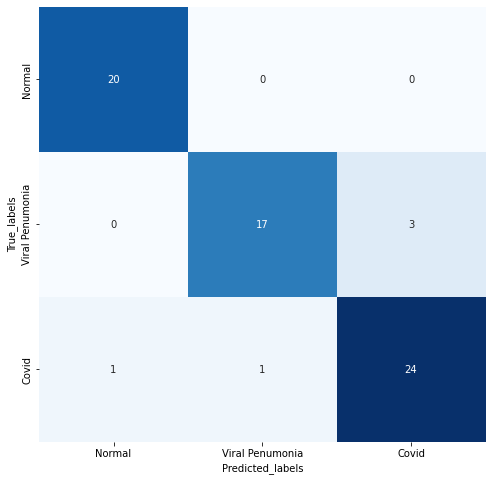

Test loss 0.2036060243844986
Test accuracy 0.9242424368858337


In [40]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_c1.predict(testtensor, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_c1.predict(testtensor, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_c1.evaluate(testtensor, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

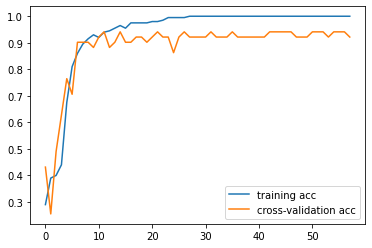

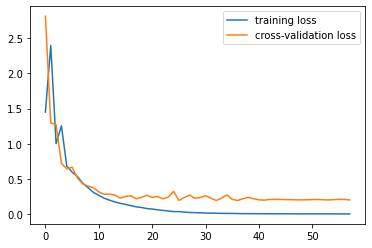

In [41]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_c1)

### Red neuronal convolucional más neuronas

In [42]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D

numero_filas = 224
numero_columnas = 224
numero_canales = 3
kernel_size = 3 # Tamaño del kernel (de cada máscara / matriz de convolución)
pool_size = 2 # Tamaño del pooling

model_c2 = Sequential()

model_c2.add(Convolution2D(256, # Número de máscaras de convolución
                        kernel_size, kernel_size, # Size of convolution kernels
                        #border_mode='valid', # Strategy to deal with borders
                        input_shape=(numero_filas, numero_columnas, numero_canales))) 
model_c2.add(Activation('relu'))
model_c2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#model_c2.add(Dropout(0.2))

# Es necesario destransfomar el tensor a un vector porque el output de la red  debería ser un vector 
# con 3 valores (que representarían las "probabilidades" de pertenencia a cada clase)
# Para ello, se utiliza una capa de tipo Flatten, que vuelve a dar estructura de vector
# y sobre la cual, se podría volver a añadir el clasificador anterior (un perceptrón multicapa)
        
from keras.layers.core import Flatten
model_c2.add(Flatten())
model_c2.add(Dense(256))
model_c2.add(Activation('relu'))
#model_c2.add(Dropout(0.2))
model_c2.add(Dense(128)) 
model_c2.add(Activation('relu'))
#model_c2.add(Dropout(0.4))
model_c2.add(Dense(3))
model_c2.add(Activation('softmax'))
model_c2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 74, 74, 256)       7168      
                                                                 
 activation_20 (Activation)  (None, 74, 74, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 256)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 350464)            0         
                                                                 
 dense_19 (Dense)            (None, 256)               89719040  
                                                                 
 activation_21 (Activation)  (None, 256)               0         
                                                      

In [43]:
# Compilación de la red
import tensorflow as tf
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=15)

callbacks_list = [early]

model_c2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Se entrena el modelo

history_c2=model_c2.fit(
    traintensor, # datos de entrenamiento
    Y_train, # variable target
    batch_size=128, # tamaño del batch
    epochs=500, # número de ciclos 
    validation_split=0.2, # tabla de validación
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list
)

Epoch 1/500
2/2 [==============================] - 9s 3s/step - loss: 7.0701 - accuracy: 0.3750 - val_loss: 12.5891 - val_accuracy: 0.2745
Epoch 2/500
2/2 [==============================] - 6s 3s/step - loss: 12.0259 - accuracy: 0.2900 - val_loss: 4.0370 - val_accuracy: 0.2549
Epoch 3/500
2/2 [==============================] - 7s 2s/step - loss: 4.0485 - accuracy: 0.3450 - val_loss: 3.7869 - val_accuracy: 0.4902
Epoch 4/500
2/2 [==============================] - 6s 3s/step - loss: 3.3213 - accuracy: 0.4500 - val_loss: 0.6800 - val_accuracy: 0.7647
Epoch 5/500
2/2 [==============================] - 7s 3s/step - loss: 0.8259 - accuracy: 0.6100 - val_loss: 1.0118 - val_accuracy: 0.4902
Epoch 6/500
2/2 [==============================] - 5s 2s/step - loss: 0.7836 - accuracy: 0.6450 - val_loss: 0.7353 - val_accuracy: 0.8039
Epoch 7/500
2/2 [==============================] - 5s 2s/step - loss: 0.6063 - accuracy: 0.8650 - val_loss: 0.6049 - val_accuracy: 0.7843
Epoch 8/500
2/2 [===============

Clases predichas= [2 2 0 2 0 2 0 0 0 1 1 1 2 1 1 1 0 0 2 0 0 1 0 2 1 0 2 2 2 2 1 2 2 0 1 1 1
 2 0 1 2 2 1 1 2 2 0 1 0 2 1 1 2 1 2 0 1 0 2 1 1 2 0 2 0 2]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.91      1.00      0.95        20
           2       1.00      0.96      0.98        26

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



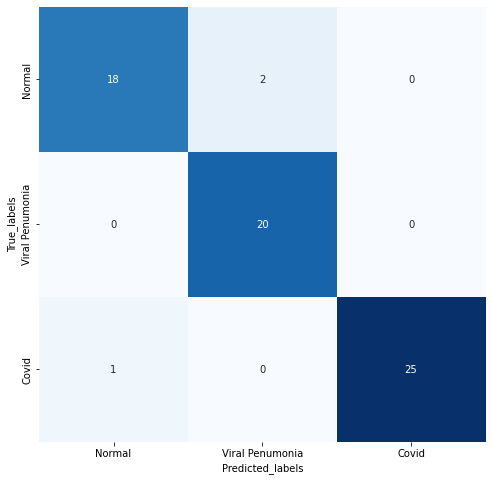

Test loss 0.1537843495607376
Test accuracy 0.9545454382896423


In [44]:
# Aplicamos el modelo sobre los datos de test
prediccion_probabilidades = model_c2.predict(testtensor, verbose = 0)
# print("Probabilidades predichas=",prediccion_probabilidades) # Si se quieren ver todas las probabilidades

# Vemos las predicciones realizadas y las evaluamos
prediccion_clases = np.argmax(model_c2.predict(testtensor, verbose = 0), axis=-1)
print("Clases predichas=",prediccion_clases)
print(classification_report(y_test,prediccion_clases))

# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_test = confusion_matrix(y_test, prediccion_clases)

# Para representarla con mapa de calor
import pandas as pd
dataframe = pd.DataFrame(confusion_matrix_test)
import seaborn as sns

plt.figure(figsize=(8, 8))
hm = sns.heatmap(confusion_matrix_test, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
plt.show()

# Valor de la función de pérdida y accuracy
score = model_c2.evaluate(testtensor, Y_test, verbose = 0)
print("Test loss", score[0])
print("Test accuracy", score[1])

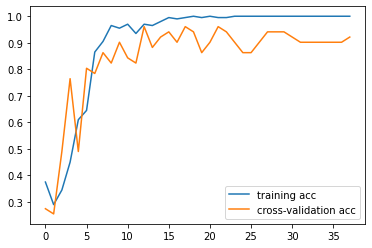

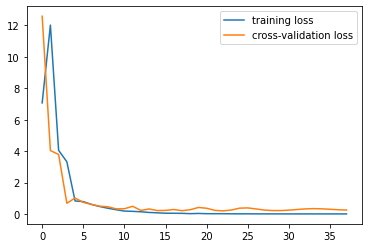

In [45]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='cross-validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='cross-validation loss')
    plt.legend();

plot_learning_curve(history_c2)

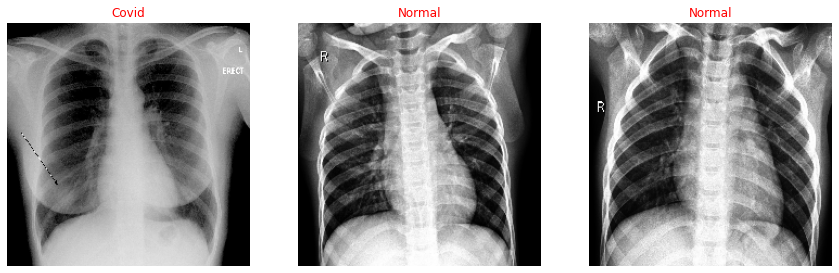

In [46]:
#Extract wrong classification index
wrong_pred = np.where(y_test!= prediccion_clases)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(X_test[n])
    plt.title("Normal" if y_test[n] == 0 else "Viral Pneumonia" if y_test[n] == 1 else "Covid",color='r')
    plt.axis("off")

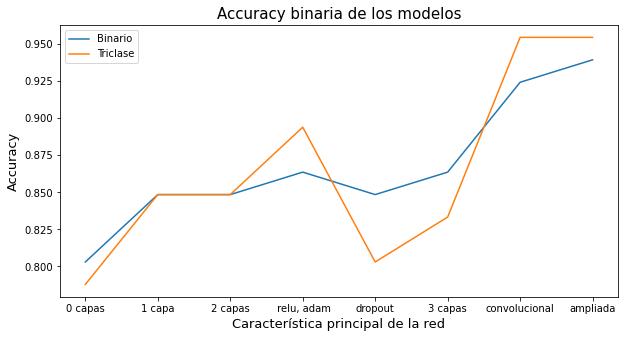

In [47]:
import numpy as np
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
x=['0 capas', '1 capa', '2 capas', ' relu, adam', 'dropout', '3 capas', 'convolucional', 'ampliada']
y1=[0.8030303120613098, 0.8484848737716675, 0.8484848737716675, 0.8636363744735718, 0.8484848737716675, 
    0.8636363744735718, 0.9242424368858337, 0.939393937587738]
y2=[0.7878787878787879, 0.8484848737716675, 0.8484848737716675, 0.893939393939394, 0.8030303120613098,
    0.8333333333333333, 0.95454545454545455, 0.95454545454545455]

plt.plot(x,y1,label="Binario")
plt.plot(x,y2,label="Triclase")

plt.title("Accuracy binaria de los modelos",fontsize=15)
plt.xlabel("Característica principal de la red",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()